In [3]:
import pandas as pd
import numpy as np
import pydicom
from glob import glob
import os
import cv2
import ast
import sys
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [4]:
data_dir = '/Volumes/Samsung_T5/siim-covid19-detection'
train_dir = data_dir + '/' + 'train/original'
test_dir = data_dir + '/' + 'test/original'
train_trans_dir = data_dir + '/' + 'train/trans'
test_trans_dir = data_dir + '/' + 'test/trans'
train_img_csv = pd.read_csv('{}/train_image_level.csv'.format(data_dir))
train_study_csv = pd.read_csv('{}/train_study_level.csv'.format(data_dir))
train_study_csv['id'] = train_study_csv['id'].str.replace('_study', "")
train_study_csv.rename({'id':'StudyInstanceUID'}, axis=1, inplace=True)
merge_csv = train_img_csv.merge(train_study_csv, on='StudyInstanceUID')
merge_csv['id'] = merge_csv['id'].str.replace('_image', '.dcm')
img_list = list(merge_csv['id'])
img_files = []
train_imgs = []
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        imgname = os.path.join(dirname, filename)
        img_files.append(imgname)
for img in img_list:
    for file in img_files:
        if img==file.split('/')[-1]:
            train_imgs.append(file)
merge_csv['img_path'] = train_imgs
merge_csv.to_csv('{}/merge_csv.csv'.format(data_dir))

In [4]:
merge_csv.head(10)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,img_path
0,000a312787f2.dcm,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
1,000c3a3f293f.dcm,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
2,0012ff7358bc.dcm,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
3,001398f4ff4f.dcm,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,/Volumes/Samsung_T5/siim-covid19-detection/tra...
4,001bd15d1891.dcm,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
5,0022227f5adf.dcm,"[{'x': 1857.2065, 'y': 508.30565, 'width': 376...",opacity 1 1857.2065 508.30565 2233.23384 907.8...,84543edc24c2,0,0,1,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
6,0023f02ae886.dcm,NaN,none 1 0 0 1 1,2fa400b873f5,1,0,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
7,002e9b2128d0.dcm,"[{'x': 276.72917, 'y': 627.42968, 'width': 910...",opacity 1 276.72917 627.42968 1187.31776 2283....,0717c8ac304f,0,1,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
8,00326161e51e.dcm,"[{'x': 542.96057, 'y': 364.37257, 'width': 590...",opacity 1 542.96057 364.37257 1133.32317999999...,a81050391441,0,1,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...
9,0044e449aae1.dcm,"[{'x': 1703.78756, 'y': 938.29333, 'width': 91...",opacity 1 1703.78756 938.29333 2614.8275599999...,b60f2d2cc642,0,1,0,0,/Volumes/Samsung_T5/siim-covid19-detection/tra...


(3488, 4256)
/Volumes/Samsung_T5/siim-covid19-detection/train/original/0a1a3dd9e738/79de130ea278/64a776818efe.dcm


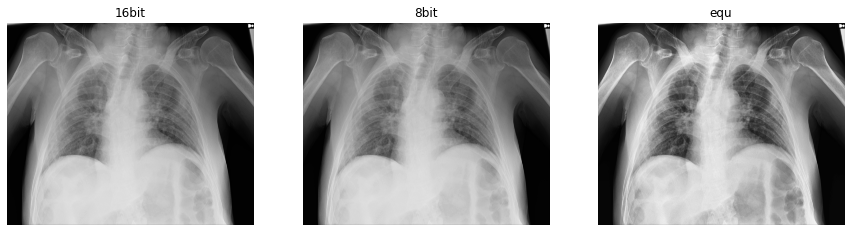

In [51]:
train_files = glob('{}/*/*/*.dcm'.format(train_dir))
d = pydicom.dcmread(train_imgs[0])
img = d.pixel_array
img8 = np.zeros(img.shape)  # dummy変数
img8 = cv2.convertScaleAbs(img-np.min(img), img8, 255/(np.max(img)-np.min(img)), beta=0) #  2021/6/22修正
img8 = img8.astype(np.uint8)
#hsv = cv2.cvtColor(img8, cv2.COLOR_BGR2HSV)
#h,s,v = cv2.split(hsv)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
img_equ = clahe.apply(img8)
print(img.shape)

print(train_files[0])
plt.figure(figsize=(15,15))
plt.subplot(1,3,1); plt.imshow(img); plt.title("16bit"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img8); plt.title("8bit"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_equ); plt.title("equ"); plt.axis('off')
plt.gray()
plt.show()

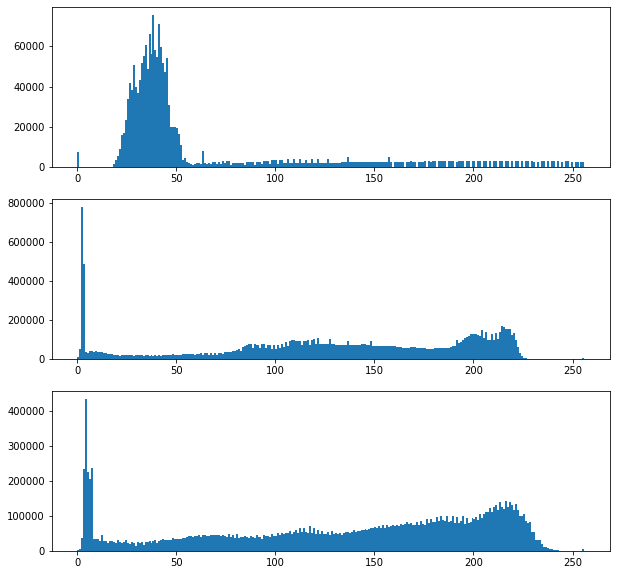

In [52]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1); plt.hist(img.ravel(),256,[0,256])
plt.subplot(3,1,2); plt.hist(img8.ravel(),256,[0,256])
plt.subplot(3,1,3); plt.hist(img_equ.ravel(),256,[0,256])
plt.show()

## dicom画像をpngに変換(いらないと思う)

In [53]:
'''
def readDicom2png(fname, save_path):
    ds = pydicom.dcmread(fname)
    img = ds.pixel_array
    #ds = pydicom.dcmread(fname)
    #wc = ds.WindowCenter
    #ww = ds.WindoWidth
    #img = ds.pixel_array
    
    #表示画素値の最大と最小を計算する
    #max = wc + ww/2
    #min = wc - ww/2
    #print("wc=",wc, "ww=",ww, "max=",max, "min=",min)
    
    #ウィンドニング処理
    #img = 255*(img-min)/(max-min)
    #img[img>255] = 255
    #img[img<0] = 0
    cv2.imwrite(save_path, img, [cv2.IMWRITE_JPEG_QUALITY, 100])
    
for i in train_imgs:
    readDicom2png(i, '{}/{}/{}/{}.png'.format(train_trans_dir, i.split('/')[6], i.split('/')[7], re.split('[/.]', i)[-2]))
'''

'\ndef readDicom2png(fname, save_path):\n    ds = pydicom.dcmread(fname)\n    img = ds.pixel_array\n    #ds = pydicom.dcmread(fname)\n    #wc = ds.WindowCenter\n    #ww = ds.WindoWidth\n    #img = ds.pixel_array\n    \n    #表示画素値の最大と最小を計算する\n    #max = wc + ww/2\n    #min = wc - ww/2\n    #print("wc=",wc, "ww=",ww, "max=",max, "min=",min)\n    \n    #ウィンドニング処理\n    #img = 255*(img-min)/(max-min)\n    #img[img>255] = 255\n    #img[img<0] = 0\n    cv2.imwrite(save_path, img, [cv2.IMWRITE_JPEG_QUALITY, 100])\n    \nfor i in train_imgs:\n    readDicom2png(i, \'{}/{}/{}/{}.png\'.format(train_trans_dir, i.split(\'/\')[6], i.split(\'/\')[7], re.split(\'[/.]\', i)[-2]))\n'

## 画像の表示

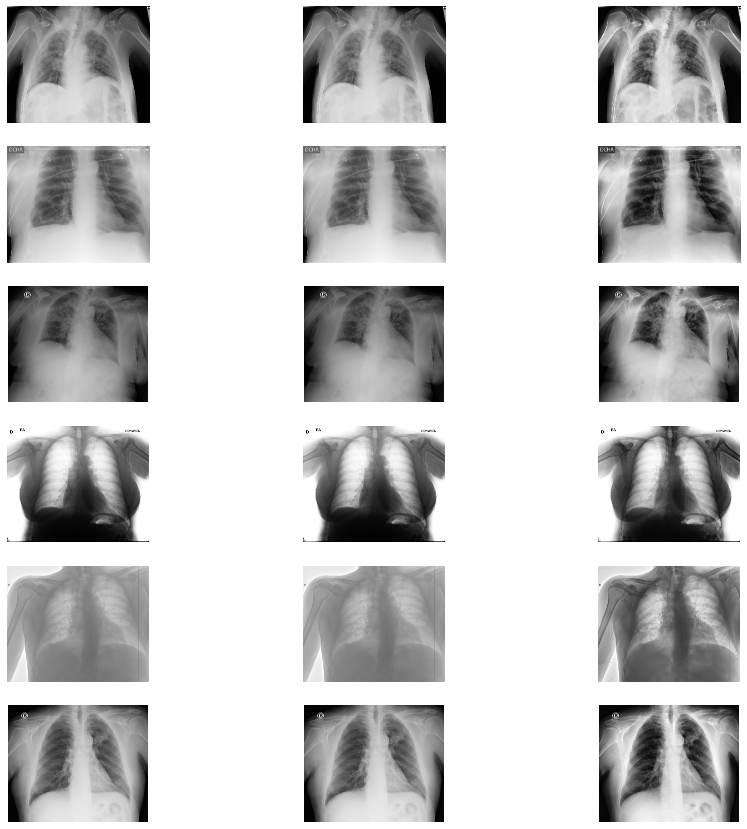

In [56]:
'''
for row in merge_csv.itertuples():
    #plt.subplot(int(len(merge_csv['img_path'])/2), 2, row[0]+1)
    img = pydicom.dcmread(row[9])
    train_img = img.pixel_array
    
    if row[5] == 1:
        plt.title('Negative')
    elif row[6] == 1:
        plt.title('Typical')
    elif row[7] == 1:
        plt.title('Indeterminate')
    elif row[8] == 1:
        plt.title('Atypical')
    else:
        break
    
    plt.imshow(train_img)
    plt.gray()
    plt.axis('off')
    plt.show()
'''

imgs = []
for i in train_imgs[0:6]:
    img = pydicom.dcmread(i)
    img = img.pixel_array
    img_trans = (img - np.mean(img))/np.std(img)*16+64
    img8 = np.zeros(img.shape)  # dummy変数
    img8 = cv2.convertScaleAbs(img-np.min(img), img8, 255/(np.max(img)-np.min(img)), beta=0) 
    img8 = img8.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
    img_equ = clahe.apply(img8)
    imgs.append(img)
    imgs.append(img_trans)
    imgs.append(img_equ)

shownum = 18
cnt = 0
while(1):
    f, ax = plt.subplots(6,3, figsize=(15,15))
    ar = ax.ravel()
    for i in range(shownum):
        ar[i].axis('off')
        if i < shownum:
            ar[i].imshow(imgs[cnt])
            cnt += 1
    plt.show()
    break

In [83]:
import re
print(re.split('[/.]', train_imgs[0]))

['', 'Volumes', 'Samsung_T5', 'siim-covid19-detection', 'train', 'original', '5776db0cec75', '81456c9c5423', '000a312787f2', 'dcm']


In [85]:
print('{}/{}/{}/{}.png'.format(train_trans_dir, train_imgs[0].split('/')[6], train_imgs[0].split('/')[7], re.split('[/.]', train_imgs[0])[-2]))

/Volumes/Samsung_T5/siim-covid19-detection/train/trans/5776db0cec75/81456c9c5423/000a312787f2.png


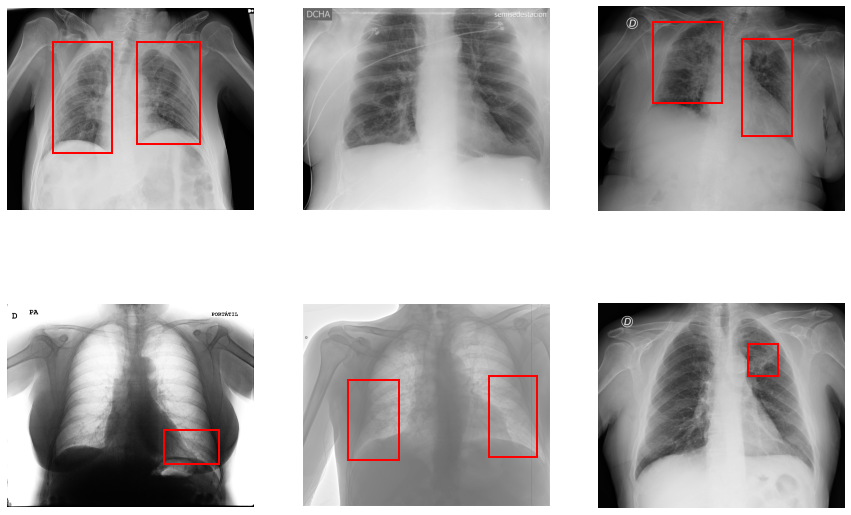

In [39]:
n = 6
#title = ["Typical", "Negative", "Typical", "Atyplical", "Typical", "Indeterminate"]
f, ax = plt.subplots(2,3, figsize=(15, 10))
ax = ax.ravel()
for i in range(n):
    img = pydicom.dcmread(merge_csv.loc[i, 'img_path'])
    img = img.pixel_array
    #box
    if (merge_csv.loc[i, 'boxes'] == merge_csv.loc[i, 'boxes']):
        boxes = ast.literal_eval(merge_csv.loc[i, 'boxes'])
        for box in boxes:
            x, y, width, height = int(box['x']), int(box['y']), int(box['width']), int(box['height'])
            rect = patches.Rectangle((x,y), width, height, linewidth=2 ,edgecolor='r', facecolor='none')
            ax[i].add_patch(rect)
    #plt.title(title[i])
    ax[i].axis('off')
    ax[i].imshow(img, cmap='gray')
    

In [148]:
import re
print(re.split('[{}:'',]', merge_csv['boxes'][0]))

['[', "'x'", ' 789.28836', " 'y'", ' 582.43035', " 'width'", ' 1026.65662', " 'height'", ' 1917.30292', '', ' ', "'x'", ' 2245.91208', " 'y'", ' 591.20528', " 'width'", ' 1094.66162', " 'height'", ' 1761.54944', ']']


In [106]:
merge_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6334 entries, 0 to 6333
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6334 non-null   object
 1   boxes                     4294 non-null   object
 2   label                     6334 non-null   object
 3   StudyInstanceUID          6334 non-null   object
 4   Negative for Pneumonia    6334 non-null   int64 
 5   Typical Appearance        6334 non-null   int64 
 6   Indeterminate Appearance  6334 non-null   int64 
 7   Atypical Appearance       6334 non-null   int64 
 8   img_path                  6334 non-null   object
dtypes: int64(4), object(5)
memory usage: 494.8+ KB


In [10]:
for row in range(9):
    if (merge_csv.loc[row, 'boxes'] == merge_csv.loc[row, 'boxes']):
        boxes = ast.literal_eval(merge_csv.loc[row, 'boxes'])
    print(boxes)

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]
[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]
[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]
[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]
[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]
[{'x': 1857.2065, 'y': 508.30565, 'width': 376.02734, 'height': 399.52911}]
[{'x': 1857.2065, 'y': 508.30565, 'width': 376.02734, 'height': 399.52911}]
[{'x': 276.72917, 'y': 627.42968, 'width': 910.58859, 'height': 1655.81519}, {'x': 1864.18229, 'y': 745.22656, 'width': 875.06262, 'height': 1535.09888}]
[{'x': 542.96057, 'y': 364.37257, '

In [44]:
for i in range(6):
    img = pydicom.dcmread(merge_csv.loc[i, 'img_path'])
    img = img.pixel_array
    img_res = cv2.resize(img, (256,256), interpolation=cv2.INTER_NEAREST)
    print(img.shape)
    

(3488, 4256)
(2320, 2832)
(2544, 3056)
(3520, 4280)
(2800, 3408)
(2539, 3050)


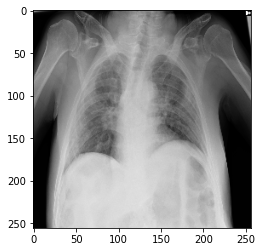

In [10]:
d = pydicom.dcmread(train_imgs[0])
img = d.pixel_array
'''
img8 = np.zeros(img.shape)  # dummy変数
img8 = cv2.convertScaleAbs(img-np.min(img), img8, 255/(np.max(img)-np.min(img)), beta=0) #  2021/6/22修正
img8 = img8.astype(np.uint8)
'''
res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
plt.imshow(res)
plt.gray()
plt.show()

In [16]:
label_cols = ['Negative for Pneumonia','Typical Appearance',
            'Indeterminate Appearance','Atypical Appearance']
merge_csv[label_cols].values

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [25]:
print(merge_csv.shape)

(6334, 9)


In [59]:
train_img = []
for row in range(len(merge_csv)):
    train_img.append(merge_csv.loc[row, 'img_path'])
print(merge_csv.loc[1, 'id'].split('.')[0])

000c3a3f293f


## classごとに画像をjpgに変換して分類(Imagedatageneraterを使うための前準備)

In [10]:
import os 
import matplotlib.pyplot as plt
import pydicom
import pylibjpeg
import gdcm
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut

data_dir = '/Volumes/Samsung_T5/siim-covid19-detection'
classes_path = data_dir + '/train/study_class' 
negative_path = './train/study_class/Negative'
typical_path = './train/study_class/Typical'
indeterminate_path = './train/study_class/Indeterminate'
atypical_path = './train/study_class/Atypical'
merge_csv = pd.read_csv( '/Volumes/Samsung_T5/siim-covid19-detection/merge_csv.csv')

os.makedirs(negative_path, exist_ok=True)
os.makedirs(typical_path, exist_ok=True)
os.makedirs(indeterminate_path, exist_ok=True)
os.makedirs(atypical_path, exist_ok=True)

def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def resize (array, size, keep_ratio=False, resample=Image.LANCZOS):
    im = Image.fromarray(array) #generate image from array
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im


for row in tqdm(range(len(merge_csv))):
    #img = pydicom.dcmread(merge_csv.loc[row, 'img_path'])
    #img = img.pixel_array
    #img8 = np.zeros(img.shape)  # dummy変数
    #img8 = cv2.convertScaleAbs(img-np.min(img), img8, 255/(np.max(img)-np.min(img)), beta=0) 
    #img8 = img.astype(np.uint8)
    file_path = merge_csv.loc[row, 'img_path']
    xray = read_xray(file_path)
    img = resize(xray, size=256)
    
    if merge_csv.loc[row, 'Negative for Pneumonia'] == 1:
        #cv2.imwrite('{}/Negative/{}.dcm'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]), img8)
        img.save('{}/Negative/{}.jpg'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]))
    elif merge_csv.loc[row, 'Typical Appearance'] == 1:
        #cv2.imwrite('{}/Typical/{}.dcm'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]), img8)
        img.save('{}/Typical/{}.jpg'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]))
    elif merge_csv.loc[row, 'Indeterminate Appearance'] == 1:
        #cv2.imwrite('{}/Indeterminate/{}.dcm'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]), img8)
        img.save('{}/Indeterminate/{}.jpg'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]))
    elif merge_csv.loc[row, 'Atypical Appearance'] == 1:
        #cv2.imwrite('{}/Atypical/{}.dcm'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]), img8)
        img.save('{}/Atypical/{}.jpg'.format(classes_path, merge_csv.loc[row, 'id'].split('.')[0]))
        

  0%|          | 0/6334 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


## Convert to JPG 1024px

In [64]:
import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut
%matplotlib inline

def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def resize (array, size, keep_ratio=False, resample=Image.LANCZOS):
    im = Image.fromarray(array) #generate image from array
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im

merge_csv = pd.read_csv( '/Volumes/Samsung_T5/siim-covid19-detection/merge_csv.csv')
file_path = merge_csv.loc[1, 'img_path']

xray = read_xray(file_path)
img = resize(xray, size=1024)
img.save(file_path.replace('dcm', 'jpg'))

## modering ResNet

In [2]:
import sys
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages')

In [3]:
import numpy as np
import pandas as pd
import pydicom
from glob import glob
import sys, os
import shutil
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import tensorflow as tf
from keras import backend as K
#from keras.models import Sequential, Model
#from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, ReLU, Flatten, Dense, Add, Dropout
#from keras.merge import add
from keras.regularizers import l2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

'''
def _clear_dir(path):
    if os.path.exist(path):
        shutil.rmtree(path)
    os.mkdir(path)

def read_img(file_path):
    img = pydicom.dcmread(file_path)
    img = img.pixel_array
    return cv2.resize(img, dsize=(img_row, img_col), interpolation=cv2.INTER_CUBIC)
'''

#ResNet50の定義(クラス)
class ResidualBlock(Model):
    def __init__(self, channel_in=64, channel_out=64):
        super().__init__()
        
        channel = channel_out / 4
        
        self.conv1 = Conv2D(channel, kernel_size=(1,1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size=(3,3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel*4, kernel_size=(1,1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(x)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(x)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av1(h)
        return y
    
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
    
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size=(1,1), padding='same')
    
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        
        self._layers = [
            Conv2D(64, input_shape=input_shape, kernel_size=(7,7), strides=(2,2), padding='same'),
            BatchNormalization(),
            Activation(tf.nn.relu),
            MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256,256) for _ in range(2)
            ],
            Conv2D(512, kernel_size=(1,1), strides=(2,2)),
            [
                ResidualBlock(512,512) for _ in range(4)
            ],
            Conv2D(1024, kernel_size=(1,1), strides=(2,2)),
            [
                ResidualBlock(1024,1024) for _ in range(6)
            ],
            Conv2D(2048, kernel_size=(1,1), strides=(2,2)),
            [
                ResidualBlock(2048,2048) for _ in range(3)
            ],
            GlobalAveragePooling2D(),
            Dense(1000, activation=tf.nn.relu),
            Dense(output_dim, activation=tf.nn.softmax),
        ]
    
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)
            else:
                x = layer(x)
        return x

## Model Summeary

In [45]:
model = ResNet50((1024, 1024, 1), 4)
model.build(input_shape = (None, 1024, 1024, 1))
model.summary()

Model: "res_net50_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1262 (Conv2D)         multiple                  3200      
_________________________________________________________________
batch_normalization_1176 (Ba multiple                  256       
_________________________________________________________________
activation_1176 (Activation) multiple                  0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling multiple                  0         
_________________________________________________________________
residual_block_384 (Residual multiple                  75904     
_________________________________________________________________
residual_block_385 (Residual multiple                  231296    
_________________________________________________________________
residual_block_386 (Residual multiple                 

## Training

In [5]:
import numpy as np
import pandas as pd
import pydicom
from glob import glob
import sys, os
import shutil
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import tensorflow as tf
from keras import backend as K
#from keras.models import Sequential, Model
#from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, ReLU, Flatten, Dense, Add, Dropout
#from keras.merge import add
from keras.regularizers import l2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

data_dir = data_dir = '/Volumes/Samsung_T5/siim-covid19-detection'
train_dir = data_dir + '/' + 'train/study_class'
test_dir = data_dir + '/' + 'test/original'
n_folds = 5
epochs = 20
img_row, img_col = 1024, 1024
batch_size = 8

datagen = ImageDataGenerator(
        rescale = 1. / 255,
        rotation_range=3,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=False,
        validation_split=0.2
)

train_gen = datagen.flow_from_directory(
      train_dir,
      target_size=(img_row, img_col),
      batch_size=batch_size,
      class_mode='categorical',
      color_mode='grayscale',
      subset='training'
)

valid_gen = datagen.flow_from_directory(
      train_dir,
      target_size=(img_row, img_col),
      batch_size=batch_size,
      class_mode='categorical',
      color_mode='grayscale',
      subset='validation'
)

weight_path = '{}/weight_path'.format(data_dir)
cp_callback = ModelCheckpoint(
    filepath =weight_path,
    save_weight_only=True,
    save_best_only=True,
    monitor= 'val_loss',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=3
)

#model_fit
def trainer():
    Model = ResNet50((1024, 1024, 1), 4)
    #Model.build(input_shape = (None, 256, 256, 1))
    Model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
    return Model

print("\n\n__Start training")
model = trainer()        
model.fit(
    train_gen,
    #steps_per_epoch=5070/batch_size,  # 5070 is train data length
    validation_data = valid_gen,
    #validation_steps=1265/batch_size, # 1265 is validation data length
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [cp_callback, early_stopping],
    shuffle = True,
    verbose = 1
)


Found 5070 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


__Start training
Epoch 1/20
  1/634 [..............................] - ETA: 12:33:19 - loss: 1.6772 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [16]:
pip install gdcm

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement gdcm (from versions: none)
ERROR: No matching distribution found for gdcm
Note: you may need to restart the kernel to use updated packages.


In [25]:
import sys
import pprint

pprint.pprint(sys.path)


['/Users/yuta/JupyterLab/kaggle/covid19',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python37.zip',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/lib-dynload',
 '',
 '/Users/yuta/Library/Python/3.7/lib/python/site-packages',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/site-packages',
 '/Users/yuta/Library/Python/3.7/lib/python/site-packages/IPython/extensions',
 '/Users/yuta/.ipython']


In [8]:
pip show numpy

Name: numpy
Version: 1.19.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /Users/yuta/Library/Python/3.7/lib/python/site-packages
Requires: 
Required-by: tensorflow, tensorboard, seaborn, scipy, scikit-learn, pylibjpeg, pylibjpeg-rle, pylibjpeg-openjpeg, pandas, opt-einsum, opencv-python, matplotlib, labelme, Keras-Preprocessing, imgviz, h5py
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip show pydicom

Name: pydicom
Version: 2.1.2
Summary: Pure python package for DICOM medical file reading and writing
Home-page: https://github.com/pydicom/pydicom
Author: Darcy Mason and contributors
Author-email: darcymason@gmail.com
License: MIT
Location: /Users/yuta/Library/Python/3.7/lib/python/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import pprint
pprint.pprint(sys.path)

['/Users/yuta/JupyterLab/kaggle/covid19',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python37.zip',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/lib-dynload',
 '',
 '/Users/yuta/Library/Python/3.7/lib/python/site-packages',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/site-packages',
 '/Users/yuta/Library/Python/3.7/lib/python/site-packages/IPython/extensions',
 '/Users/yuta/.ipython']


In [34]:
pip show matplotlib

Name: matplotlib
Version: 3.2.2
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /Users/yuta/Library/Python/3.7/lib/python/site-packages
Requires: cycler, numpy, kiwisolver, python-dateutil, pyparsing
Required-by: seaborn, labelme, imgviz
Note: you may need to restart the kernel to use updated packages.


In [4]:
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages')

In [6]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 16.9 MB 10.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
model = ResNet50((1024, 1024, 1), 64)
model.build(input_shape = (None, 1024, 1024,  0))
model.summary()

NameError: name 'ResNet50' is not defined